# Goodreads Reading List Recommender Project (Recommender)

In [1]:
# Import basic data libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import other functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

## Importing and Inspecting

In [2]:
# Read in the cleaned books table
books = pd.read_pickle('../Data/books.pkl')

# Look at the shape of the books table
print(books.shape)

# Look at the head of the books table
books.head(2)

(13525, 18)


,work_id,isbn,isbn13,original_title,author,original_publication_year,num_pages,description,image_url,reviews_count,text_reviews_count,5_star_ratings,4_star_ratings,3_star_ratings,2_star_ratings,1_star_ratings,ratings_count,avg_rating
0,2919130,1416534601,9781416534600,Nocturnes,John Connolly,2004.0,NaN,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,8820,338,1118,1601,1029,190,58,3996,3.9
1,52087333,NaN,NaN,Draw Play,Tia Lewis,2016.0,NaN,Jake:\nI can't believe my coach assigned me a ...,https://s.gr-assets.com/assets/nophoto/book/11...,2482,204,204,353,274,77,29,937,3.7


In [3]:
# Look at the head of the engineered genres table
genres = pd.read_pickle('../Data/genres.pkl')

# Look at the shape of the genres table
print(genres.shape)

# Look at the head of the books table
genres.head(2)

(13525, 17)


,work_id,biography,children,comics,crime,fantasy,fiction,graphic,historical fiction,history,mystery,non-fiction,paranormal,poetry,romance,thriller,young-adult
0,104,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0
1,114,1,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0


In [4]:
# Read in the similar_books table
similar_books = pd.read_pickle('../Data/similar_books.pkl')

# Look at the shape of the books table
print(similar_books.shape)

# Look at the head of the books table
similar_books.head(2)

(13525, 12116)


,work_id,1000406,10017864,10018961,1003370,1003711,1003821,1003876,1003952,1004338,...,990467,99163,99257,99258,9932848,993612,994121,99441,997358,997754
0,104,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,114,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Recommenders

In [5]:
def get_percentiles(df, column):
    """
    Prints out seven percentiles of an input column from the input DataFrame. Specifically, the 1st, 5th, 
    25th, 50th, 75th, 95th, and 99th percentiles.
    
    Inputs:
        - df (pd.DataFrame)
        - column (str)
    Returns:
        - None
    """
    percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    for percentile in percentiles:
        print(f'{column} - {percentile} percentile: {df[column].quantile(percentile)}')

### Content-Based Filtering

From the EDA section, it was found that original_publication_year and num_pages have extreme outliers. Therefore, I will clip them before scaling to ensure accurate and balanced recommendations.

In [6]:
# Initialise a list of my favourite books for quick testing
fav_books = ["Brat'ia Karamazovy", 'Anna Karenina', 'Idiot', 'The Catcher in the Rye', 'Nineteen Eighty-Four']

# Find my favourite books in the books table
favourites = books[books['original_title'].isin(fav_books)]

------------------------------------------------------------------------------------------------------------------------------

In [7]:
# Check the percentiles for the original_publication_year column since there are outliers
get_percentiles(books, 'original_publication_year')

original_publication_year - 0.01 percentile: 1884.06
original_publication_year - 0.05 percentile: 1967.0
original_publication_year - 0.25 percentile: 2006.0
original_publication_year - 0.5 percentile: 2011.0
original_publication_year - 0.75 percentile: 2014.0
original_publication_year - 0.95 percentile: 2016.0
original_publication_year - 0.99 percentile: 2017.0


In [8]:
# Check the percentiles for the num_pages column since there are outliers
get_percentiles(books, 'num_pages')

num_pages - 0.01 percentile: 39.94
num_pages - 0.05 percentile: 128.0
num_pages - 0.25 percentile: 260.0
num_pages - 0.5 percentile: 334.0
num_pages - 0.75 percentile: 391.0
num_pages - 0.95 percentile: 551.2999999999993
num_pages - 0.99 percentile: 792.239999999998


In [9]:
# Create clipped columns of original_publication_year and num_pages to reduce the influence of outliers
books['opy_clipped'] = books['original_publication_year'].clip(lower=books['original_publication_year'].quantile(0.05))
books['np_clipped'] = books['num_pages'].clip(upper=books['num_pages'].quantile(0.99).round())

In [10]:
# Put the clipped original_publication_year and num_pages columns on a 0-1 scale so it matches the dummy variable scale
mms = MinMaxScaler()
books_scaled = mms.fit_transform(books[['opy_clipped', 'np_clipped']])
books = pd.concat([books, pd.DataFrame(books_scaled, columns=['opy_scaled', 'np_scaled'])], axis=1)

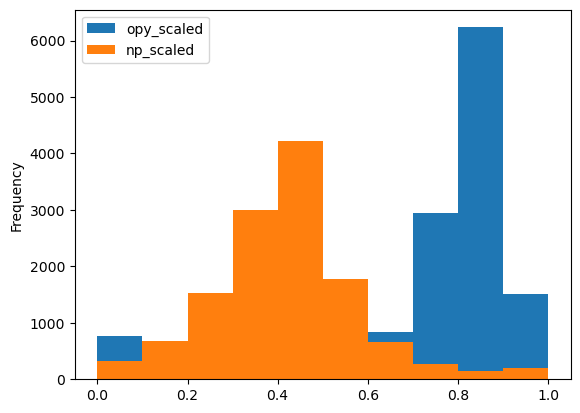

In [11]:
# Look at the distribution of the scaled and clipped columns
books[['opy_scaled', 'np_scaled']].plot.hist();

In [12]:
# Initialise the input matrix that will be initialised into the cosine_similarity function
model_data = genres.copy()

# Join the scaled and clipped original_publication_year and num_pages columns to X
model_data = genres.merge(books[['work_id', 'opy_scaled', 'np_scaled']], on='work_id')

# Select columns [TO BE DONE]
#X = model_data[]

In [13]:
# Create a cosine matrix for similar genres
#co_sim = pd.DataFrame(cosine_similarity(model_data.iloc[1:]), columns=model_data.work_id, index=model_data.work_id)
#co_sim.columns.name = None
#co_sim.index.name = None

------------------------------------------------------------------------------------------------------------------------------

In [14]:
# Find out the number of different authors there are in the books table
print(f"Number of Authors: {books['author'].nunique()}")

# Find out how many authors have more than one book in the books table
print(f"Number of Multiple Publishing Authors: {sum(books['author'].value_counts() > 1)}")

# Find out how many books there are in the books table
print(f'Number of Books: {books.shape[0]}')

Number of Authors: 5554
Number of Multiple Publishing Authors: 2214
Number of Books: 13525


There are too many authors to create dummies that can be inputted into the cosine_similarity function. Therefore, instead, I plan to increase the cosine_similarity of two books by x (to be decided later) if they are written by the same author.

------------------------------------------------------------------------------------------------------------------------------

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Compute base cosine similarity matrix
cos_sim = cosine_similarity(X)

# Step 2: Convert authors to list (same order as X)
authors = books['author'].tolist()

# Step 3: Add boost where authors match
boost_value = 0.05  # You can experiment with this

for i in range(len(authors)):
    for j in range(len(authors)):
        if i != j and authors[i] == authors[j]:
            cos_sim[i][j] += boost_value
            # Optional: cap similarity at 1.0
            cos_sim[i][j] = min(cos_sim[i][j], 1.0)

NameError: name 'X' is not defined